# __Pacchetto A — “Adozione & copertura dei divieti”__

## Obiettivo: raccontare quanto e dove i divieti smoke-free sono stati adottati, e come si sono diffusi nel tempo.

__1. Mappa coropletica 2022: “Venue coverage index” per Paese__

- Cosa: indice 0–8 che somma la presenza del divieto in 8 luoghi (ristoranti, bar/caffè, uffici, università, trasporto pubblico, luoghi pubblici indoor, strutture sanitarie, edifici governativi).

- Insight: fotografia globale della copertura normativa.

- Dataset: i 8 “Tobacco smoke-free … (national legislation)”.

__2. Area chart per Regione OMS: % di Paesi con copertura “alta” (≥6/8) nel tempo__

- Cosa: per anno, quota di Paesi della regione che ha adottato la maggior parte dei divieti.

- Insight: velocità di diffusione regionale.

- Dataset: gli stessi 8, aggregati per regione+anno.

__3. Small multiples (6 pannelli): “adozione per venue” nel tempo per ogni Regione OMS__

- Cosa: 6 mini-grafici (una regione ciascuno); linee per ogni venue con % di Paesi coperti.

- Insight: quali luoghi sono stati regolati prima/dopo in ogni regione (es. ospedali quasi ovunque presto, bar/ristoranti più lenti).

- Dataset: i 8 “smoke-free …”.

__4. Barre orizzontali (Top 15 Paesi): copertura per venue nel 2022__

- Cosa: stacked-bar per Paese (ordine per indice), colori per venue.

- Insight: classifica dei più completi e pattern di venue mancanti.

- Dataset: i 8 “smoke-free …” (ultimo anno ≤2022).

## __1. Mappa coropletica 2022: "Venue coverage index" per Paese__

__Cosa mostra questo grafico__

- È una mappa coropletica dell’indice di copertura smoke-free (0–8) per ogni Paese, calcolato come somma dei divieti “Yes” (da Value) in otto luoghi chiave:
health-care, scuole (escl. università), edifici governativi, uffici al chiuso, ristoranti, pub/bar/caffè, trasporto pubblico, altri spazi pubblici al chiuso.
Per ciascun Paese prendiamo l’ultimo anno disponibile ≤ 2022.

- Colore più scuro = più luoghi coperti (fino a 8/8).

- Colore chiaro = copertura parziale o bassa (pochi “Yes”).

- Con l’hover vedi ISO3/Paese e l’indice (e la % su 8).

__Come leggerla / cosa si capisce a colpo d’occhio__

- Europa, parte delle Americhe e vari Paesi ad alto reddito tendono ad avere coperture alte (6–8/8): quadro normativo più completo in tutti (o quasi) gli ambienti.

- Africa e alcune aree di Medio Oriente/Sud-Est asiatico mostrano più spesso coperture intermedie o basse, segnalando ambiti ancora scoperti (es. ristoranti o “altri spazi indoor”).

- Differenze intra-regionali emergono bene (es. Sud America in media più scuro di Centro America; Nord Africa/Levant più chiari di Europa).

__Perché è utile nella sezione “P” (Protect)__

- Condensa in un numero facilmente confrontabile quanto un Paese protegge le persone dal fumo passivo nei contesti che contano.

- È un ponte naturale verso gli altri grafici della sezione “P”:

- trend % di Paesi ≥6/8 per regione nel tempo,

- small multiples per singolo luogo (chi ha il ban in ristoranti? in uffici?),

- graduatoria Paesi/regioni.

In [5]:
# === P — Grafico A1 (fix definitivo): mappa copertura smoke-free basata su VALUE Yes/No ===
import pandas as pd, numpy as np, glob, re, os
import plotly.express as px
from pathlib import Path

def pick_col(df, *aliases):
    cols = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in cols:
            return cols[a.lower()]
    raise KeyError(f"Colonna non trovata tra {aliases} in: {list(df.columns)}")

def yesno_to_bin(s):
    s = s.astype(str).str.strip().str.lower()
    return s.map({"yes":1, "no":0}).fillna(0).astype(int)

VENUE_PATTERNS = {
    "healthcare":      "health_care_facilities",
    "education_no_uni":"education_facilities_except_universities",
    "government":      "government_facilities",
    "offices":         "indoor_offices",
    "restaurants":     "restaurants",
    "pubs_bars":       "pubs,_bars_and_cafes",
    "public_transport":"public_transport",
    "other_indoor":    "other_indoor_public_spaces",
}

# trova file
all_csv = sorted(glob.glob("P/*.csv")) + sorted(glob.glob("./P/*.csv"))
files = {k: [f for f in all_csv if re.search(pat, os.path.basename(f), flags=re.I)][0]
         for k,pat in VENUE_PATTERNS.items()
         if any(re.search(pat, os.path.basename(f), flags=re.I) for f in all_csv)}

# carica + mappa Yes/No
frames, diag = [], []
for key, path in files.items():
    df = pd.read_csv(path, encoding="utf-8-sig")
    year_col = pick_col(df, "Period","TimeDim","Year")
    iso_col  = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    loc_col  = pick_col(df, "Location","Country","SpatialDim")

    # colonna valore prioritaria: VALUE (Yes/No). Fallback: qualunque colonna che contenga Yes/No.
    if "Value" in df.columns:
        val = yesno_to_bin(df["Value"])
        chosen = "Value"
    else:
        # fallback: cerca una colonna con yes/no
        chosen = next((c for c in df.columns
                       if {"yes","no"}.issubset(set(df[c].astype(str).str.lower().unique()))), None)
        if chosen is None:
            # ultimo fallback: qualsiasi colonna testuale contenente "yes" o "no"
            for c in df.columns:
                s = df[c].astype(str).str.lower()
                if s.str.contains("yes").any() or s.str.contains("no").any():
                    chosen = c; break
        val = yesno_to_bin(df[chosen]) if chosen else pd.Series(0, index=df.index)

    tmp = df[[iso_col, loc_col, year_col]].copy()
    tmp.rename(columns={iso_col:"ISO3", loc_col:"Country", year_col:"Year"}, inplace=True)
    tmp["ban"]  = val
    tmp["Year"] = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp.dropna(subset=["ISO3","Year"]).sort_values(["ISO3","Year"])

    latest = tmp[tmp["Year"] == 2022]
    base   = latest if not latest.empty else tmp.groupby("ISO3").tail(1)
    base   = base.drop_duplicates("ISO3", keep="last")
    base["venue"] = key
    frames.append(base[["ISO3","Country","venue","ban","Year"]])

    n1 = int(base["ban"].sum()); nTot = int(base["ban"].count())
    diag.append((key, os.path.basename(path), chosen, n1, nTot))

print("\n[Diagnostica VALUE Yes/No]")
for k,f,c,n1,nTot in diag:
    print(f" - {k:15s} col={c:>10s}  ban=1: {n1}/{nTot}")

df_all = pd.concat(frames, ignore_index=True)

# indice 0–8
wide = df_all.pivot_table(index=["ISO3","Country"], columns="venue", values="ban",
                          aggfunc="max", fill_value=0).reset_index()
for k in VENUE_PATTERNS:
    if k not in wide.columns:
        wide[k] = 0
wide["coverage_index"] = wide[list(VENUE_PATTERNS)].sum(axis=1).astype(int)
wide["coverage_pct"]   = 100 * wide["coverage_index"] / 8.0

# mappa
fig = px.choropleth(
    wide, locations="ISO3", color="coverage_index", hover_name="Country",
    hover_data={"coverage_index": True, "coverage_pct": True},
    color_continuous_scale=px.colors.sequential.Blues, range_color=(0,8),
    title="Smoke-free coverage index (0–8) — 2022",
)
fig.update_geos(showcountries=True, showframe=False, showcoastlines=False, landcolor="rgb(242,242,242)")
fig.update_layout(margin=dict(l=0, r=0, t=70, b=0), coloraxis_colorbar=dict(title="Indice 0–8"), font=dict(size=12))

Path("P/outputs").mkdir(parents=True, exist_ok=True)
import plotly.io as pio
pio.write_html(fig, "P/outputs/protect_map_coverage_index.html", include_plotlyjs="cdn")
fig.show()

print("\nTop 10 per copertura:")
display(wide.sort_values("coverage_index", ascending=False).head(10)[["ISO3","Country","coverage_index"]])



[Diagnostica VALUE Yes/No]
 - healthcare      col=     Value  ban=1: 142/195
 - education_no_uni col=     Value  ban=1: 148/195
 - government      col=     Value  ban=1: 117/195
 - offices         col=     Value  ban=1: 97/195
 - restaurants     col=     Value  ban=1: 93/195
 - pubs_bars       col=     Value  ban=1: 88/195
 - public_transport col=     Value  ban=1: 123/195
 - other_indoor    col=     Value  ban=1: 43/195



Top 10 per copertura:


venue,ISO3,Country,coverage_index
24,BRB,Barbados,8
100,LCA,Saint Lucia,8
144,PRY,Paraguay,8
80,IRN,Iran (Islamic Republic of),8
137,PER,Peru,8
136,PAN,Panama,8
31,CHL,Chile,8
66,GMB,Gambia,8
85,JAM,Jamaica,8
56,ETH,Ethiopia,8


## __2. Area chart per Regione OMS: % di Paesi con copertura “alta” (≥6/8) nel tempo__

__Cosa mostra questo grafico (A2)__

- Oggetto: quota di Paesi (in %) per regione OMS che raggiungono una copertura “alta” di politiche smoke-free (almeno 6 divieti su 8 luoghi chiave) nel tempo.

- Scala temporale: 2007→2022 (marker sui tick; linee continue tra punti osservati).

- Metodo: per ogni Paese-anno sommiamo quanti divieti “Yes” sui 8 venue; è “alto” se ≥6. Per evitare distorsioni, consideriamo solo Paesi-anno con un numero minimo di venue osservati (soglia adattiva, es. ≥6, altrimenti ≥5, …).

- Lettura: ogni linea è una regione OMS. L’ordinata è la penetrazione regionale delle politiche forti (quanti Paesi su 100 nella regione stanno a ≥6/8).

__Come si relaziona al primo grafico (A1 – mappa)__

- A1 (mappa): fotografia spaziale dell’ultimo dato disponibile ≤2022 → “dove” siamo arrivati Paese per Paese (indice 0–8).

- A2 (linee): dinamica regionale → “quanto” e “come” le regioni hanno accumulato Paesi con copertura alta lungo gli anni.

__Insieme rispondono a:__

- Dove sono oggi i cluster di copertura alta/bassa (A1).

- Quali regioni sono migliorate prima/più velocemente e quando (A2).

__Coerenza con A1 (cosa aspettarsi)__

- Se nella mappa vedi molti Paesi scuri in Americhe, in A2 dovresti trovare la linea delle Americhe in alto nel 2022 (alta % di Paesi ≥6/8).

- Se una regione (es. Europa o Pacifico Occidentale) mostra un mix cromatico nella mappa, A2 mostrerà una quota intermedia e magari crescita più graduale.

- Dove la mappa evidenzia ampie aree chiare (copertura bassa), A2 si posizionerà più in basso o mostrerà progressi tardivi.

__Cosa ci permette di capire in più (valore aggiunto)__

- Velocità di adozione: pendenze ripide indicano fasi di policy-push (es. implementazioni sincronizzate).

- Plateau/arretramenti: linee piatte o che oscillano segnalano stallo o instabilità nell’adozione/qualità dei divieti.

- Convergenza/divergenze regionali: se le linee si avvicinano nel tempo → convergenza; se si separano → crescente disuguaglianza di policy.

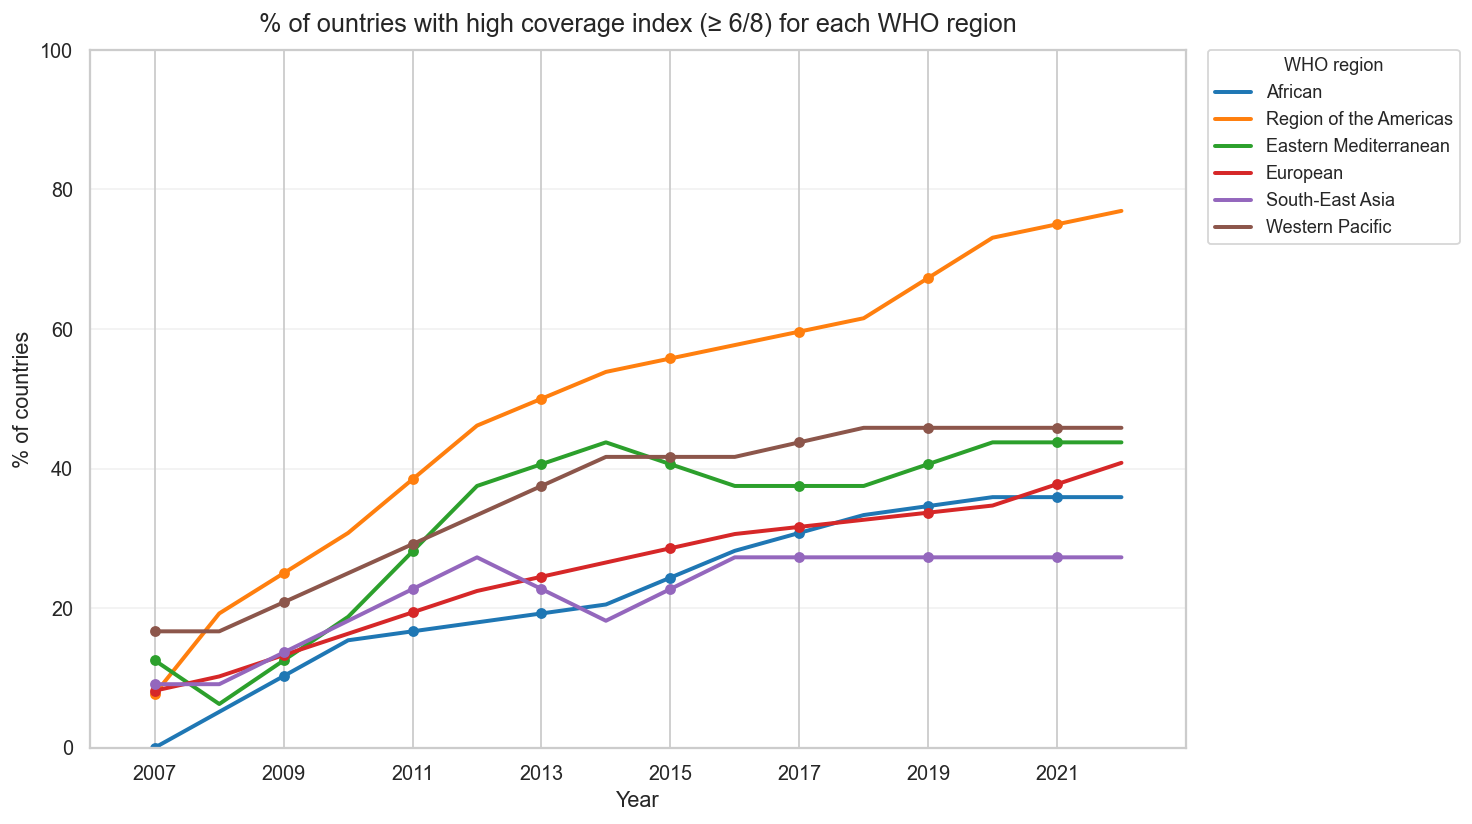

In [10]:
# === P — Grafico A2 (fix): % Paesi con copertura smoke-free alta (≥6/8) per regione OMS, nel tempo ===
import pandas as pd, numpy as np, glob, re, os
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

YEAR_MIN, YEAR_MAX = 2007, 2022
HIGH_THRESH = 6
TRY_MIN_VENUES = [6,5,4,3,2]   # completezza venue/anno: scala se i dati sono scarsi

PALETTE_REGION = {
    "African Region": "#1f77b4",
    "Region of the Americas": "#ff7f0e",
    "Eastern Mediterranean Region": "#2ca02c",
    "European Region": "#d62728",
    "South-East Asia Region": "#9467bd",
    "Western Pacific Region": "#8c564b",
}
REGION_ORDER = [
    "African Region", "Region of the Americas", "Eastern Mediterranean Region",
    "European Region", "South-East Asia Region", "Western Pacific Region"
]

VENUE_PATTERNS = {
    "healthcare":      "health_care_facilities",
    "education_no_uni":"education_facilities_except_universities",
    "government":      "government_facilities",
    "offices":         "indoor_offices",
    "restaurants":     "restaurants",
    "pubs_bars":       "pubs,_bars_and_cafes",
    "public_transport":"public_transport",
    "other_indoor":    "other_indoor_public_spaces",
}

def pick_col(df, *aliases):
    cols = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in cols: return cols[a.lower()]
    raise KeyError(f"Colonna non trovata tra {aliases} in: {list(df.columns)}")

def yesno_to_bin(s):
    s = s.astype(str).str.strip().str.lower()
    return s.map({"yes":1, "no":0}).fillna(0).astype(int)

def norm_region(x):
    s = str(x).strip()
    m = s.lower()
    if m in {"afr","african region","africa"}: return "African Region"
    if m in {"amr","region of the americas","americas"}: return "Region of the Americas"
    if m in {"emr","eastern mediterranean region","eastern mediterranean"}: return "Eastern Mediterranean Region"
    if m in {"eur","european region","europe"}: return "European Region"
    if m in {"sear","south-east asia region","south-east asia","south east asia"}: return "South-East Asia Region"
    if m in {"wpr","western pacific region","western pacific"}: return "Western Pacific Region"
    return np.nan

# -------- 1) Mappa ISO3 -> Regione OMS dal folder M/ --------
def get_iso_region_map_from_M():
    m_candidates = sorted(glob.glob("M/*age*standard*.csv")) + sorted(glob.glob("./M/*age*standard*.csv"))
    if not m_candidates:
        return pd.DataFrame(columns=["ISO3","Region"])
    dfm = pd.read_csv(m_candidates[0], encoding="utf-8-sig")
    iso_col   = pick_col(dfm, "SpatialDimValueCode","ISO3","ISO")
    regioncol = next((c for c in dfm.columns if c.lower() in {"parentlocation","who region","who_region","region"}), None)
    if not regioncol:
        return pd.DataFrame(columns=["ISO3","Region"])
    out = (dfm[[iso_col, regioncol]].rename(columns={iso_col:"ISO3", regioncol:"Region"})
              .dropna().drop_duplicates())
    out["Region"] = out["Region"].map(norm_region)
    out = out.dropna().drop_duplicates("ISO3")
    return out

iso_region_map = get_iso_region_map_from_M()

# -------- 2) Carica i CSV della sezione P e costruisci indice 0–8 per Paese–Anno --------
all_csv = sorted(glob.glob("P/*.csv")) + sorted(glob.glob("./P/*.csv"))
files = {}
for key, pat in VENUE_PATTERNS.items():
    hit = [f for f in all_csv if re.search(pat, os.path.basename(f), flags=re.I)]
    if hit: files[key] = hit[0]
if len(files) < 6:
    raise RuntimeError("Non trovo abbastanza CSV dei venue in ./P/.")

long_list = []
for key, path in files.items():
    df = pd.read_csv(path, encoding="utf-8-sig")
    year_col = pick_col(df, "Period","TimeDim","Year")
    iso_col  = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    loc_col  = pick_col(df, "Location","Country","SpatialDim")

    # valore Yes/No
    if "Value" in df.columns:
        ban = yesno_to_bin(df["Value"])
    else:
        cand = next((c for c in df.columns
                     if {"yes","no"}.issubset(set(df[c].astype(str).str.lower().unique()))), None)
        ban = yesno_to_bin(df[cand]) if cand else pd.Series(0, index=df.index)

    tmp = df[[iso_col, loc_col, year_col]].copy()
    tmp.rename(columns={iso_col:"ISO3", loc_col:"Country", year_col:"Year"}, inplace=True)
    tmp["ban"]   = ban.values
    tmp["venue"] = key
    tmp["Year"]  = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp[(tmp["Year"] >= YEAR_MIN) & (tmp["Year"] <= YEAR_MAX)]
    long_list.append(tmp[["ISO3","Country","Year","venue","ban"]])

long = pd.concat(long_list, ignore_index=True)

# attacca la regione OMS dalla mappa di M
long = long.merge(iso_region_map, how="left", on="ISO3")

# se qualche ISO3 resta senza regione, scartalo
long = long.dropna(subset=["Region"])
long["Region"] = long["Region"].map(norm_region)
long = long.dropna(subset=["Region"])

# indice e completezza per Paese–Anno
cov = (long.groupby(["ISO3","Country","Region","Year"])
            .agg(n_obs=("ban","size"), coverage_index=("ban","sum"))
            .reset_index())
cov["high"] = (cov["coverage_index"] >= HIGH_THRESH).astype(int)

# -------- 3) Soglia di completezza dinamica (≥6 → 5 → 4 → 3 → 2) --------
chosen_min = None
agg = pd.DataFrame()
for mv in TRY_MIN_VENUES:
    eligible = cov[cov["n_obs"] >= mv]
    test = (eligible.groupby(["Region","Year"])
                  .agg(pct_high=("high", lambda s: 100*s.mean() if len(s)>0 else np.nan),
                       n_countries=("high","size"))
                  .dropna(subset=["pct_high"])
                  .reset_index())
    if not test.empty:
        chosen_min = mv
        agg = test
        break

if chosen_min is None:
    raise RuntimeError("Serie vuota: anche con soglia 2 venue/anno i dati non sono sufficienti.")

# ordina e plotta
agg["Region"] = pd.Categorical(agg["Region"], categories=REGION_ORDER, ordered=True)
agg = agg.sort_values(["Region","Year"])

# --- PLOT aggiornato ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(11.5, 6.5), dpi=130)

tick_years = list(range(2007, 2023, 2))   # 2007, 2009, ..., 2021
drawn = 0

for reg in REGION_ORDER:
    sub = agg[agg["Region"] == reg]
    if sub.empty:
        continue

    years = sub["Year"].to_numpy()
    vals  = sub["pct_high"].to_numpy()
    color = PALETTE_REGION.get(reg, "tab:gray")

    # linea sui valori reali
    ax.plot(years, vals, linewidth=2.2, color=color, label=reg.replace(" Region",""))

    # marker ai tick (interpolazione se mancano dati)
    s = pd.Series(vals, index=pd.Index(years, name="Year")).sort_index()
    s_interp = (s.reindex(sorted(set(s.index).union(tick_years)))
                  .interpolate(method="index")
                  .reindex(tick_years))
    ax.plot(s_interp.index.values, s_interp.values,
            linestyle="", marker="o", color=color, markersize=5)

    drawn += 1

ax.set_title("% of ountries with high coverage index (≥ 6/8) for each WHO region", fontsize=14, pad=10)
ax.set_ylabel("% of countries", fontsize=12)
ax.set_xlabel("Year", fontsize=12)

ax.set_xlim(2006, 2023)
ax.set_xticks(tick_years)
ax.set_ylim(0, 100)

if drawn:
    ax.legend(
        title="WHO region", frameon=True, fontsize=10, title_fontsize=10,
        loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0
    )
ax.grid(True, axis="y", alpha=0.25)

#note = f"Denominatore: Paesi con ≥{chosen_min}/8 venue osservati nello stesso anno. Soglia 'alta' = indice ≥{HIGH_THRESH}."
#ax.text(0.01, -0.12, note, transform=ax.transAxes, fontsize=9, va="top", ha="left")

plt.tight_layout()
Path("P/outputs").mkdir(parents=True, exist_ok=True)
plt.savefig("P/outputs/protect_trend_high_coverage_by_region.png", bbox_inches="tight")
plt.show()


## __3. Small multiples (6 pannelli): “adozione per venue” nel tempo per ogni Regione OMS__

__Cosa mostra, come si legge__

- Ogni pannello è una regione OMS.

- Ogni linea è un luogo/venue (ospedali, scuole, uffici, ristoranti, trasporti, ecc.).

- L’asse Y è la % di Paesi della regione che in quell’anno hanno il divieto in quel luogo.

- I pallini sono posati sui tick (2007, 2009, …, 2021) e aiutano a confrontare i progressi biennali; se una linea finisce prima del 2022 (es. “Other indoor public spaces” in alcuni pannelli) significa che per quel venue non ci sono rilevazioni più recenti.

- Le linee sono percentuali, quindi danno il “peso” del consenso regionale per ciascun ambiente.

__Come si relaziona con gli altri due__

- Grafico 1 (mappa, indice 0–8): una foto istantanea del livello complessivo di copertura per Paese (sommando 8 ambienti).
→ Gli small multiples spiegano da cosa è fatta quella somma: quali ambienti contribuiscono di più in ogni regione e dove mancano ancora divieti.

- Grafico 2 (linee %, Paesi ≥6/8 per regione): racconta quanti Paesi per regione superano una soglia “alta” di copertura nel tempo.
→ Gli small multiples mostrano il percorso per arrivarci: quali venue sono stati attivati prima, quali dopo e quali restano “colli di bottiglia” che impediscono a più Paesi di varcare la soglia ≥6/8.

__Letture rapide (coerenza con i primi due)__

- Americhe: linee alte e piuttosto allineate su più venue → coerente con mappa “scura” e con la quota elevata di Paesi ≥6/8 nel grafico 2.

- Africa: crescita graduale; sanità/educazione salgono prima, ospitalità (pub/ristoranti) e “other indoor” sono più indietro → spiega perché in A2 la % ≥6/8 è più bassa e la mappa è più chiara.

- Europa & Western Pacific: profilo ampio e abbastanza omogeneo tra venue → si riflette in una buona quota ≥6/8 e in valori d’indice medio-alti.

- Eastern Mediterranean / South-East Asia: salti per venue (es. scuole/trasporti prima, hospitality dopo) → la disomogeneità per ambienti spiega andamenti meno lineari in A2 e indici intermedi in mappa.

__Perché è utile__

- Individua priorità di policy per regione: es. se ristoranti e bar restano indietro, sono quelli che limitano l’indice 0–8 e l’ingresso nel gruppo ≥6/8.

- Permette confronti mirati (entro regione e tra regioni) su tempi di adozione e diffusione dei divieti per ambiente.

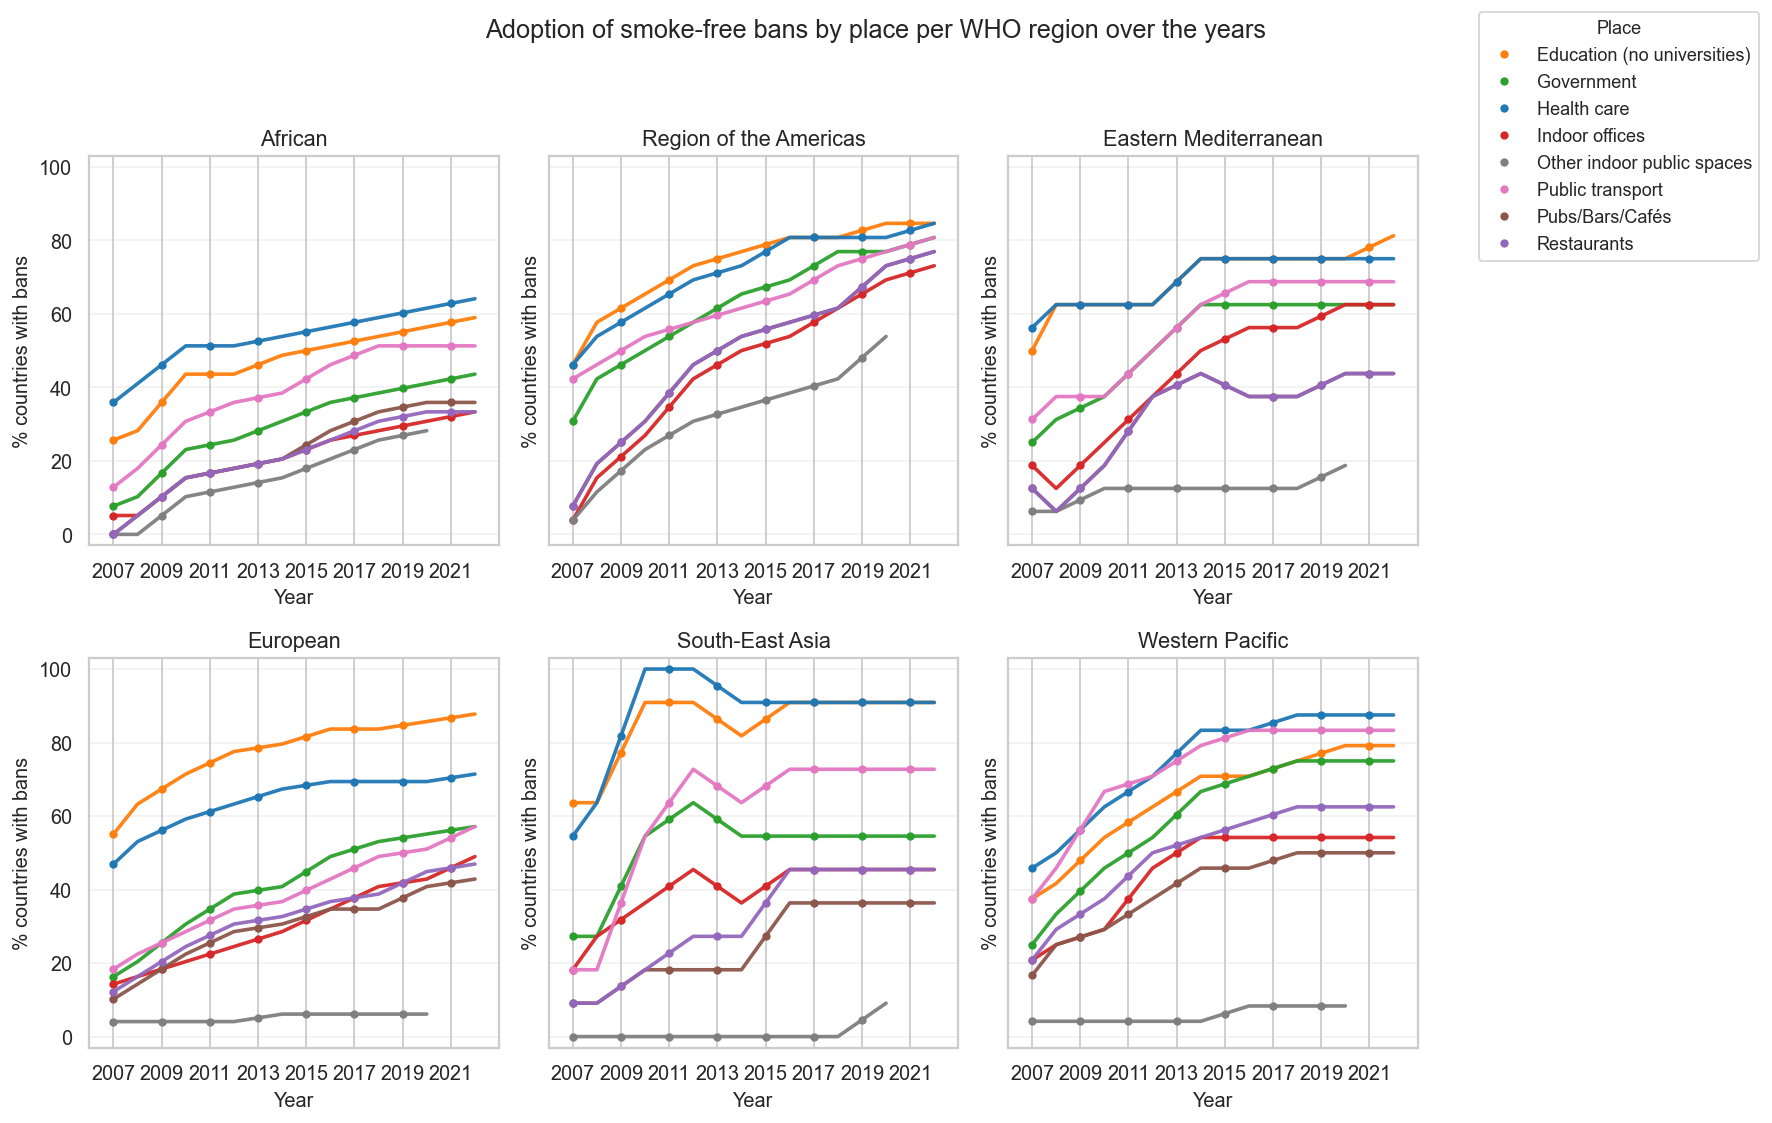

In [13]:
# === P — Grafico A3 (rev2): Small multiples — adozione per venue nel tempo per ogni Regione OMS ===
import pandas as pd, numpy as np, glob, re, os
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Parametri ----------------
YEAR_MIN, YEAR_MAX = 2007, 2022
REGION_ORDER = [
    "African Region", "Region of the Americas", "Eastern Mediterranean Region",
    "European Region", "South-East Asia Region", "Western Pacific Region"
]
tick_years = list(range(YEAR_MIN, YEAR_MAX + 1, 2))  # 2007, 2009, ..., 2021 (2022 è comunque nel dominio)

# etichette/colore per venue
VENUE_LABELS = {
    "healthcare":       "Health care",
    "education_no_uni": "Education (no universities)",
    "government":       "Government",
    "offices":          "Indoor offices",
    "restaurants":      "Restaurants",
    "pubs_bars":        "Pubs/Bars/Cafés",
    "public_transport": "Public transport",
    "other_indoor":     "Other indoor public spaces",
}
VENUE_COLORS = {
    "healthcare":       "#1f77b4",
    "education_no_uni": "#ff7f0e",
    "government":       "#2ca02c",
    "offices":          "#d62728",
    "restaurants":      "#9467bd",
    "pubs_bars":        "#8c564b",
    "public_transport": "#e377c2",
    "other_indoor":     "#7f7f7f",
}
VENUE_PATTERNS = {
    "healthcare":      "health_care_facilities",
    "education_no_uni":"education_facilities_except_universities",
    "government":      "government_facilities",
    "offices":         "indoor_offices",
    "restaurants":     "restaurants",
    "pubs_bars":       "pubs,_bars_and_cafes",
    "public_transport":"public_transport",
    "other_indoor":    "other_indoor_public_spaces",
}

# ---------------- Util ----------------
def pick_col(df, *aliases):
    cols = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in cols: return cols[a.lower()]
    raise KeyError(f"Colonna non trovata tra {aliases} in: {list(df.columns)}")

def yesno_to_bin(s):
    s = s.astype(str).str.strip().str.lower()
    return s.map({"yes":1, "no":0}).fillna(0).astype(int)

def norm_region(x):
    s = str(x).strip().lower()
    if s in {"afr","african region","africa"}: return "African Region"
    if s in {"amr","region of the americas","americas"}: return "Region of the Americas"
    if s in {"emr","eastern mediterranean region","eastern mediterranean"}: return "Eastern Mediterranean Region"
    if s in {"eur","european region","europe"}: return "European Region"
    if s in {"sear","south-east asia region","south-east asia","south east asia"}: return "South-East Asia Region"
    if s in {"wpr","western pacific region","western pacific"}: return "Western Pacific Region"
    return np.nan

def get_iso_region_map_from_M():
    m_candidates = sorted(glob.glob("M/*age*standard*.csv")) + sorted(glob.glob("./M/*age*standard*.csv"))
    if not m_candidates:
        return pd.DataFrame(columns=["ISO3","Region"])
    dfm = pd.read_csv(m_candidates[0], encoding="utf-8-sig")
    iso_col   = pick_col(dfm, "SpatialDimValueCode","ISO3","ISO")
    regioncol = next((c for c in dfm.columns if c.lower() in {"parentlocation","who region","who_region","region"}), None)
    if not regioncol:
        return pd.DataFrame(columns=["ISO3","Region"])
    out = (dfm[[iso_col, regioncol]].rename(columns={iso_col:"ISO3", regioncol:"Region"})
              .dropna().drop_duplicates())
    out["Region"] = out["Region"].map(norm_region)
    out = out.dropna().drop_duplicates("ISO3")
    return out

iso_region_map = get_iso_region_map_from_M()

# ---------------- Caricamento dati venue P/ e % adozione ----------------
all_csv = sorted(glob.glob("P/*.csv")) + sorted(glob.glob("./P/*.csv"))
files = {}
for key, pat in VENUE_PATTERNS.items():
    hit = [f for f in all_csv if re.search(pat, os.path.basename(f), flags=re.I)]
    if hit: files[key] = hit[0]
if len(files) < 6:
    raise RuntimeError("Non trovo abbastanza CSV dei venue in ./P/ (servono i dataset smoke-free per 6–8 venue).")

recs = []
for key, path in files.items():
    df = pd.read_csv(path, encoding="utf-8-sig")
    year_col = pick_col(df, "Period","TimeDim","Year")
    iso_col  = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    loc_col  = pick_col(df, "Location","Country","SpatialDim")

    # mappa Yes/No
    ban = yesno_to_bin(df["Value"]) if "Value" in df.columns else pd.Series(0, index=df.index)
    tmp = df[[iso_col, loc_col, year_col]].copy()
    tmp.rename(columns={iso_col:"ISO3", loc_col:"Country", year_col:"Year"}, inplace=True)
    tmp["ban"]   = ban.values
    tmp["venue"] = key
    tmp["Year"]  = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp[(tmp["Year"] >= YEAR_MIN) & (tmp["Year"] <= YEAR_MAX)]

    # regione
    tmp = tmp.merge(iso_region_map, how="left", on="ISO3")
    tmp["Region"] = tmp["Region"].map(norm_region)
    tmp = tmp.dropna(subset=["Region","Year"])

    # % Paesi con ban per (Regione, Anno, Venue)
    g = (tmp.groupby(["Region","Year"])
            .agg(n_yes=("ban","sum"), n_tot=("ban","count"))
            .reset_index())
    g["pct"] = np.where(g["n_tot"]>0, 100*g["n_yes"]/g["n_tot"], np.nan)
    g["venue"] = key
    recs.append(g[["Region","Year","venue","pct"]])

series = pd.concat(recs, ignore_index=True)
series["Region"] = pd.Categorical(series["Region"], categories=REGION_ORDER, ordered=True)
series = series.sort_values(["Region","venue","Year"])

# ---------------- Small multiples con marker sui tick (clippati all'intervallo reale) + etichette x su TUTTI ----------------
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(14.5, 8.8), dpi=130, sharex=False, sharey=True)
axes = axes.ravel()

for i, reg in enumerate(REGION_ORDER):
    ax = axes[i]
    sub = series[series["Region"] == reg]
    if sub.empty:
        ax.axis("off"); continue

    for vkey, g in sub.groupby("venue"):
        g = g.sort_values("Year")
        color = VENUE_COLORS.get(vkey, None)
        label = VENUE_LABELS.get(vkey, vkey)

        # 1) linea sui valori REALI
        ax.plot(g["Year"], g["pct"], color=color, linewidth=2, alpha=0.95)

        # 2) marker ESATTAMENTE sui tick compresi tra min/max anno reale
        years_real = g["Year"].to_numpy()
        yvals_real = g["pct"].to_numpy()
        s = pd.Series(yvals_real, index=pd.Index(years_real, name="Year")).sort_index()

        # clip dei tick entro il range reale (evita point "fantasma" dopo l'ultimo anno disponibile,
        # es. Other indoor public spaces che spesso termina a 2020)
        clip_ticks = [t for t in tick_years if t >= years_real.min() and t <= years_real.max()]

        # Interpolazione solo sull'intervallo reale
        s_interp = (s.reindex(sorted(set(s.index).union(clip_ticks)))
                      .interpolate(method="index")
                      .reindex(clip_ticks))

        ax.plot(s_interp.index.values, s_interp.values,
                linestyle="", marker="o", markersize=3.6, color=color, label=label)

    # Titolo e assi in OGNI pannello
    ax.set_title(reg.replace(" Region",""), fontsize=12, pad=6)
    ax.set_xlabel("Year", fontsize=11)
    ax.set_ylabel("% countries with bans", fontsize=11)

    ax.set_xlim(YEAR_MIN-1, YEAR_MAX+1)
    ax.set_xticks(tick_years)                      # etichette anno su tutti i grafici
    ax.tick_params(axis="x", labelrotation=0)      # tutte visibili
    ax.set_ylim(-3, 103)                           # respiro verticale
    ax.grid(True, axis="y", alpha=0.25)

# Legenda globale fuori (in alto a destra)
fig.subplots_adjust(right=0.82, hspace=0.32, wspace=0.12)
handles, labels = axes[0].get_legend_handles_labels()
# dedup
keep, seen = [], set()
for h, l in zip(handles, labels):
    if l not in seen:
        keep.append((h, l)); seen.add(l)
handles, labels = zip(*keep)
fig.legend(handles, labels, title="Place", fontsize=10, title_fontsize=10,
           loc="upper left", bbox_to_anchor=(0.82, 1.0), borderaxespad=0.0, frameon=True)

fig.suptitle("Adoption of smoke-free bans by place per WHO region over the years", fontsize=14, y=0.995)
plt.tight_layout(rect=[0.03, 0.02, 0.80, 0.96])

Path("P/outputs").mkdir(parents=True, exist_ok=True)
plt.savefig("P/outputs/protect_small_multiples_venue_by_region_rev2.png", bbox_inches="tight")
plt.show()


## __4. “Protezione (P) vs Prevalenza fumo (M) per Regione OMS 2022” (scatter P vs M colorato da Complaints)__

- X: indice di protezione P (0–8, ultimo anno ≤2022).
- Y: prevalenza adulti fumatori M (ultimo anno ≤2022).
- Colore: Complaints Yes/No.
- Quadranti:

- Alto P & Alta M + Complaints = Yes → luoghi con forte regolazione ma prevalenza ancora alta → probabile pressione/attriti e quindi più segnalazioni.

- Alto P & Bassa M + Complaints No → contesto di norma più “tranquillo”.

- Cosa dice: evidenzia i Paesi dove la domanda di tutela (alta M) incontra regole stringenti (alto P): dove il malcontento potenziale è più plausibile e dove la presenza di un canale di reclamo è più “necessaria”.

- Cosa si può concludere:
    - Asse X (protezione P) – Le Americhe risultano le più avanti (≈6 su 8): è esattamente ciò che vedevamo sia nella mappa dell’indice sia nella quota di Paesi con copertura ≥6/8, dove l’AMR arrivava ~70–75% nel 2022. EMR/SEAR stanno a metà (~4.5–5), Europa un po’ più indietro (~3.5–4), Africa più bassa (~3.5): allineato con gli small multiples per venue (Americhe quasi sempre “prime”, Europa/WPR più disomogenei, Africa meno coperta).

    - Asse Y (prevalenza M) – I livelli per regione sono quelli che avevamo già: Europa e WPR più alti (~23–25%), EMR/SEAR a metà (~17–19%), Americhe più basse (~12) e Africa più bassa (~9). Combacia con la serie storica M che mostrava quei ranking nel 2022.

    - Dimensione (complaints) – Le bolle più grandi in Europa/WPR e più piccole in Africa sono plausibili: dove le normative e i canali di segnalazione sono più strutturati arrivano più “citizen complaints”. Qui il segnale misura più attivazione/monitoraggio che “malcontento” in senso negativo.

    - Relazione P–M – La correlazione quasi nulla (r≈0.05) a livello medio di regione è sensata: due forze opposte si compensano. Le Americhe hanno alto P e basso M, ma WPR ha alto P e M alto, e l’Europa ha M alto con P medio-basso; quindi la regressione globale risulta quasi piatta. (È anche un promemoria che il livello di prevalenza riflette decenni di storia, cultura, mercato e non cambia solo con l’introduzione recente dei divieti.)

    - Lettura finale - Il punto forte è che mette insieme politiche (P), esito (M) e segnalazioni in un solo colpo d’occhio e conferma quanto visto prima: Americhe sono le più “protette” e con prevalenza più bassa; Europa/WPR restano con prevalenza alta nonostante livelli di protezione non bassi, suggerendo inerzia storica e bisogno di interventi complementari (cessation, tassazione, marketing, ecc.).

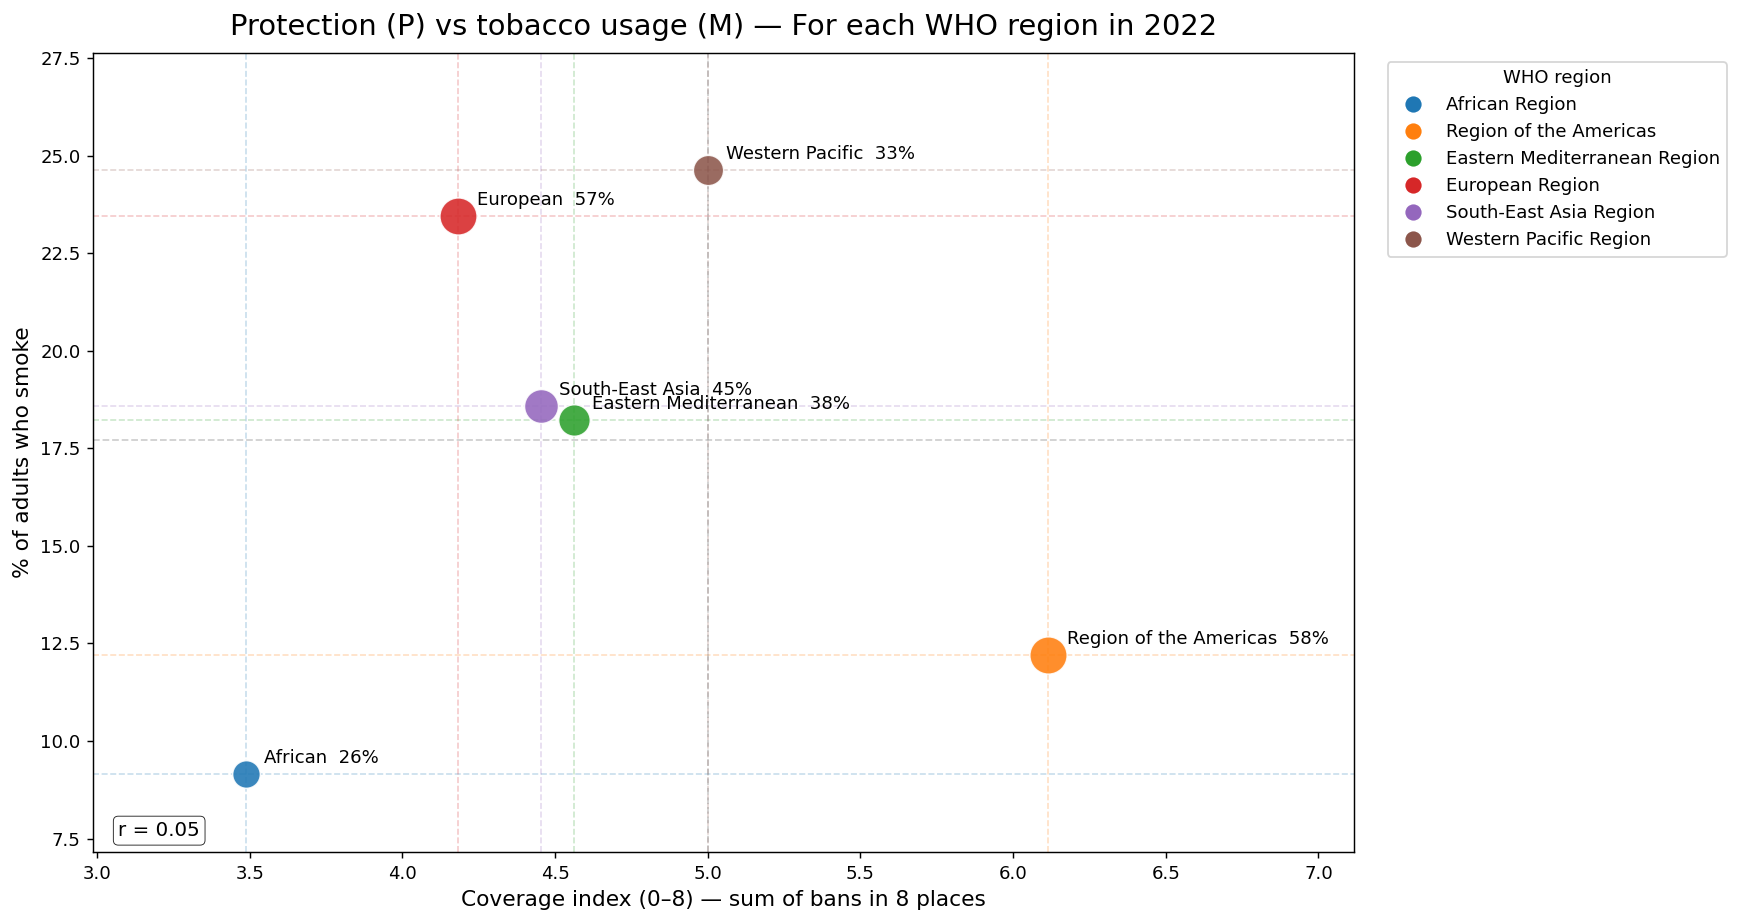

In [6]:
# === P4 — Scatter bubble per REGIONE OMS (MOD) =======================================
#     X = Protezione (P, somma divieti 0–8, ultimo dato ≤2022)
#     Y = Prevalenza fumo adulti M (age-standardized, Both, ultimo dato ≤2022)
#     Size = % Paesi con "citizen complaints" (ultimo dato ≤2022)  [solo per dimensione bolla]
#     Modifiche: niente retta obliqua; label con %; griglie tratteggiate per ogni punto;
#                figura più larga; una sola legenda (colori).
# =====================================================================================

import pandas as pd, numpy as np, glob, re, os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

YEAR_CUTOFF = 2022

# ---------- palette & ordini ----------
PALETTE_REGION = {
    "African Region": "#1f77b4",
    "Region of the Americas": "#ff7f0e",
    "Eastern Mediterranean Region": "#2ca02c",
    "European Region": "#d62728",
    "South-East Asia Region": "#9467bd",
    "Western Pacific Region": "#8c564b",
}
REGION_ORDER = [
    "African Region", "Region of the Americas", "Eastern Mediterranean Region",
    "European Region", "South-East Asia Region", "Western Pacific Region"
]
SHORT = {
    "African Region":"African", "Region of the Americas":"Region of the Americas",
    "Eastern Mediterranean Region":"Eastern Mediterranean", "European Region":"European",
    "South-East Asia Region":"South-East Asia", "Western Pacific Region":"Western Pacific"
}

VENUE_PATTERNS = {
    "healthcare":      "health_care_facilities",
    "education_no_uni":"education_facilities_except_universities",
    "government":      "government_facilities",
    "offices":         "indoor_offices",
    "restaurants":     "restaurants",
    "pubs_bars":       "pubs,_bars_and_cafes",
    "public_transport":"public_transport",
    "other_indoor":    "other_indoor_public_spaces",
}

def pick_col(df, *aliases):
    cols = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in cols: return cols[a.lower()]
    raise KeyError(f"Colonna non trovata tra {aliases} in: {list(df.columns)}")

def yesno_to_bin(series):
    s = series.astype(str).str.strip().str.lower()
    is_yes = s.str.contains(r"\byes\b", na=False)
    is_no  = s.str.contains(r"\bno\b",  na=False)
    out = pd.Series(np.where(is_yes, 1, np.where(is_no, 0, np.nan)), index=series.index).astype("float")
    out = out.fillna(pd.to_numeric(series, errors="coerce"))
    return out.fillna(0).astype(int)

def norm_region(x):
    s = str(x).strip().lower()
    if s in {"afr","african region","africa"}: return "African Region"
    if s in {"amr","region of the americas","americas"}: return "Region of the Americas"
    if s in {"emr","eastern mediterranean region","eastern mediterranean"}: return "Eastern Mediterranean Region"
    if s in {"eur","european region","europe"}: return "European Region"
    if s in {"sear","south-east asia region","south-east asia","south east asia"}: return "South-East Asia Region"
    if s in {"wpr","western pacific region","western pacific"}: return "Western Pacific Region"
    return np.nan

# ---------- (A) Mappa ISO3 -> Regione OMS dal file M (age-standardized) ----------
m_candidates = sorted(glob.glob("M/*age*standard*.csv")) + sorted(glob.glob("./M/*age*standard*.csv"))
if not m_candidates:
    raise FileNotFoundError("Non trovo il CSV M (age-standardized) in ./M/")
dfm = pd.read_csv(m_candidates[0], encoding="utf-8-sig")
iso_m   = pick_col(dfm, "SpatialDimValueCode","ISO3","ISO")
reg_m   = next((c for c in dfm.columns if c.lower() in {"parentlocation","who region","who_region","region"}), None)
year_m  = pick_col(dfm, "Period","TimeDim","Year")
sex_m   = next((c for c in dfm.columns if c.lower() in {"dim1","sex"}), None)
val_m   = next((c for c in dfm.columns if c.lower() in {"factvaluenumeric","value"}), None)
ind_m   = next((c for c in dfm.columns if c.lower() in {"indicator","indicatorname","indicator_label","indicatorlabel","gho"}), None)

dff = dfm.copy()
if ind_m:
    mask_ind = dff[ind_m].astype(str).str.contains(r"tobacco\s*smoking", flags=re.I, regex=True)
    if mask_ind.any():
        dff = dff[mask_ind]
if sex_m:
    dff = dff[dff[sex_m].astype(str).str.contains(r"\bboth\b", flags=re.I, regex=True)]
dff[val_m]  = pd.to_numeric(dff[val_m], errors="coerce")
dff[year_m] = pd.to_numeric(dff[year_m], errors="coerce")

iso_region_map = (
    dfm[[iso_m, reg_m]].rename(columns={iso_m:"ISO3", reg_m:"Region"})
      .dropna().drop_duplicates()
)
iso_region_map["Region"] = iso_region_map["Region"].map(norm_region)
iso_region_map = iso_region_map.dropna().drop_duplicates("ISO3")

m_last = (dff[dff[year_m] <= YEAR_CUTOFF]
          .sort_values([iso_m, year_m])
          .drop_duplicates(subset=[iso_m], keep="last")
          [[iso_m, val_m]]
          .rename(columns={iso_m:"ISO3", val_m:"M_prev"}))

# ---------- (B) Indice P per Paese (somma 0–8) da file in P/ ----------
p_all = sorted(glob.glob("P/*.csv")) + sorted(glob.glob("./P/*.csv"))
files_p = {}
for key, pat in VENUE_PATTERNS.items():
    hit = [f for f in p_all if re.search(pat, os.path.basename(f), flags=re.I)]
    if hit: files_p[key] = hit[0]
if len(files_p) < 6:
    raise RuntimeError("In ./P/ non trovo abbastanza CSV dei venue per calcolare l'indice P.")

long_p = []
for key, path in files_p.items():
    df = pd.read_csv(path, encoding="utf-8-sig")
    iso = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    year= pick_col(df, "Period","TimeDim","Year")
    val = next((c for c in df.columns if c.lower()=="value"), None)
    if val is None:
        val = next((c for c in df.columns
                    if {"yes","no"}.issubset(set(df[c].astype(str).str.lower().unique()))), None)
        if val is None:
            raise RuntimeError(f"Nel file {os.path.basename(path)} non trovo una colonna 'Value' con yes/no.")
    tmp = df[[iso, year, val]].copy()
    tmp.columns = ["ISO3", "Year", "Value"]
    tmp["Year"] = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp[tmp["Year"] <= YEAR_CUTOFF]
    tmp["ban"] = yesno_to_bin(tmp["Value"])
    tmp = tmp.sort_values(["ISO3","Year"]).drop_duplicates(["ISO3"], keep="last")
    tmp["venue"] = key
    long_p.append(tmp[["ISO3","venue","ban"]])

p_wide = (pd.concat(long_p, ignore_index=True)
          .pivot_table(index="ISO3", columns="venue", values="ban", aggfunc="max", fill_value=0))
for v in VENUE_PATTERNS.keys():
    if v not in p_wide.columns:
        p_wide[v] = 0
p_wide["P_index"] = p_wide[list(VENUE_PATTERNS.keys())].sum(axis=1)
p_index = p_wide["P_index"].reset_index()

# ---------- (C) Complaints per Paese (ultimo dato ≤ 2022) ----------
compl_files = sorted(glob.glob("P/*complaints*csv")) + \
              sorted(glob.glob("E/*complaints*csv")) + \
              sorted(glob.glob("./P/*complaints*csv")) + \
              sorted(glob.glob("./E/*complaints*csv"))
if not compl_files:
    raise FileNotFoundError("Non trovo il CSV dei 'citizen complaints'.")
compl = pd.read_csv(compl_files[0], encoding="utf-8-sig")
iso_c  = pick_col(compl, "SpatialDimValueCode","ISO3","ISO")
year_c = pick_col(compl, "Period","TimeDim","Year")
val_c  = next((c for c in compl.columns if c.lower()=="value"), None)
compl = compl[[iso_c, year_c, val_c]].rename(columns={iso_c:"ISO3", year_c:"Year", val_c:"Value"})
compl["Year"] = pd.to_numeric(compl["Year"], errors="coerce")
compl = compl[compl["Year"] <= YEAR_CUTOFF].sort_values(["ISO3","Year"])
compl["complaint"] = yesno_to_bin(compl["Value"])
compl_last = compl.drop_duplicates("ISO3", keep="last")[["ISO3","complaint"]]

# ---------- (D) Merge per Paese, poi aggregazione per REGIONE ----------
per_country = (pd.DataFrame({"ISO3": p_index["ISO3"]})
               .merge(p_index, on="ISO3", how="left")
               .merge(m_last,  on="ISO3", how="left")
               .merge(compl_last, on="ISO3", how="left")
               .merge(iso_region_map, on="ISO3", how="left"))

per_country = per_country.dropna(subset=["Region"])
region_df = (per_country
             .groupby("Region", as_index=False)
             .agg(
                 P_index=("P_index","mean"),
                 M_prev =("M_prev","mean"),
                 complaints_pct=("complaint", lambda s: 100 * (s.fillna(0).astype(int).mean()))
             ))
region_df["Region"] = pd.Categorical(region_df["Region"], categories=REGION_ORDER, ordered=True)
region_df = region_df.sort_values("Region")

# ---------- (E) PLOT ----------
SIZE_BASE, SIZE_SCALE = 80, 6.0
sizes = SIZE_BASE + SIZE_SCALE * region_df["complaints_pct"].clip(lower=0)

y_ref = float(region_df["M_prev"].mean())
x_ref = 5  # solo come riferimento visivo (teniamolo tratteggiato verticale)

fig, ax = plt.subplots(figsize=(13.5, 7.2), dpi=130)  # figura più larga

# (opzionale) linee di riferimento globali
ax.axvline(x_ref, ls="--", lw=1, color="#888", alpha=0.4)
ax.axhline(y_ref, ls="--", lw=1, color="#888", alpha=0.4)

# una bolla per regione + linee tratteggiate ai valori di ogni punto
for (_, r), s in zip(region_df.iterrows(), sizes):
    # guide lines per ogni punto
    ax.axvline(r["P_index"], ls="--", lw=0.9, color=PALETTE_REGION.get(r["Region"], "#999"), alpha=0.25, zorder=1)
    ax.axhline(r["M_prev"],  ls="--", lw=0.9, color=PALETTE_REGION.get(r["Region"], "#999"), alpha=0.25, zorder=1)
    # punto
    ax.scatter(r["P_index"], r["M_prev"],
               s=s, color=PALETTE_REGION.get(r["Region"], "tab:gray"),
               edgecolor="white", linewidth=0.8, alpha=0.88, zorder=3)
    # etichetta con % complaints arrotondata
    pct = f"{r['complaints_pct']:.0f}%"
    ax.text(r["P_index"]+0.06, r["M_prev"]+0.18,
            f"{SHORT.get(r['Region'], r['Region'])}  {pct}",
            fontsize=10, ha="left", va="bottom", zorder=4)

# titoli & assi in italiano
ax.set_title("Protection (P) vs tobacco usage (M) — For each WHO region in 2022",
             fontsize=16, pad=10)
ax.set_xlabel("Coverage index (0–8) — sum of bans in 8 places", fontsize=12)
ax.set_ylabel("% of adults who smoke", fontsize=12)
ax.set_xlim(max(0, region_df["P_index"].min()-0.5), region_df["P_index"].max()+1.0)
ax.set_ylim(max(0, region_df["M_prev"].min()-2), region_df["M_prev"].max()+3)

# Legenda colori (una sola)
handles_colors, labels_colors = [], []
for reg in REGION_ORDER:
    if reg in region_df["Region"].values:
        h = Line2D([0],[0], marker='o', color='w',
                   markerfacecolor=PALETTE_REGION[reg], markeredgecolor="white",
                   markersize=10, label=reg)
        handles_colors.append(h); labels_colors.append(reg)
ax.legend(handles=handles_colors, labels=labels_colors, title="WHO region",
          loc="upper left", bbox_to_anchor=(1.02, 1), frameon=True)

# r (correlazione) in basso a sinistra (opzionale)
r_val = np.corrcoef(region_df["P_index"], region_df["M_prev"])[0,1]
ax.text(0.02, 0.02, f"r = {r_val:.2f}", transform=ax.transAxes, fontsize=11,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85, lw=0.5))

plt.tight_layout()
plt.show()
